In [25]:
%matplotlib inline
from __future__ import division,print_function
import os, json
from glob import glob
import numpy as np
import scipy
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt
import utils; reload(utils)
from utils import plots, get_batches, plot_confusion_matrix, get_data
from datetime import datetime

In [6]:
#Create references to important directories we will use over and over
HOME_DIR = "/home/ubuntu/fastai/"
DATA_HOME_DIR = "/home/ubuntu/fastai/data/dogscats/"
os.chdir(DATA_HOME_DIR)
print("current dir:", os.getcwd() )

#Set path to sample/ path if desired
test_path = DATA_HOME_DIR + 'test1/' #We use all the test data
results_path=DATA_HOME_DIR + 'results/'
train_path=DATA_HOME_DIR + 'train/'
valid_path=DATA_HOME_DIR + 'valid/'
print ("test_path:", test_path)
print ("results_path:", results_path)
print ("train_path:", train_path)
print ("valid_path:", valid_path)

current dir: /home/ubuntu/fastai/data/dogscats
test_path: /home/ubuntu/fastai/data/dogscats/test1/
results_path: /home/ubuntu/fastai/data/dogscats/results/
train_path: /home/ubuntu/fastai/data/dogscats/train/
valid_path: /home/ubuntu/fastai/data/dogscats/valid/


In [10]:
os.chdir(HOME_DIR)
print("current dir:", os.getcwd() )

# Rather than importing everything manually, we'll make things easy
#   and load them all in utils.py, and just import them from there.
%matplotlib inline
import utils; reload(utils)
from utils import *
from vgg16 import Vgg16

current dir: /home/ubuntu/fastai


In [8]:
from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential
from keras.layers import Input
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image

In [11]:
batch_size=64

In [12]:
vgg = Vgg16()
model = vgg.model

In [14]:
# Use batch size of 1 since we're just doing preprocessing on the CPU
val_batches = get_batches(valid_path, shuffle=False, batch_size=1)
batches = get_batches(train_path, shuffle=False, batch_size=1)

Found 2000 images belonging to 2 classes.
Found 23000 images belonging to 2 classes.


In [16]:
print (type(val_batches))
print (type(batches))

<class 'keras.preprocessing.image.DirectoryIterator'>
<class 'keras.preprocessing.image.DirectoryIterator'>


In [18]:
val_data = get_data(valid_path)
print (val_data.shape)

Found 2000 images belonging to 2 classes.
(2000, 3, 224, 224)


In [21]:
trn_data = get_data(train_path)
print (trn_data.shape)

Found 23000 images belonging to 2 classes.
(23000, 3, 224, 224)


In [22]:
def onehot(x): return np.array(OneHotEncoder().fit_transform(x.reshape(-1,1)).todense())

In [23]:
val_classes = val_batches.classes
trn_classes = batches.classes
val_labels = onehot(val_classes)
trn_labels = onehot(trn_classes)

In [24]:
print ("trn_labels.shape:", trn_labels.shape)
print ("val_labels.shape:", val_labels.shape)

trn_labels.shape: (23000, 2)
val_labels.shape: (2000, 2)


In [26]:
print ("start")
startTime= datetime.now()
print ("startTime:", startTime)
trn_features = model.predict(trn_data, batch_size=batch_size)
timeElapsed=datetime.now()-startTime
print('Time elapsed (hh:mm:ss.ms) {}'.format(timeElapsed))



start
startTime: 2017-12-05 06:27:26.013757
Time elapsed (hh:mm:ss.ms) 0:09:21.274293


In [27]:
startTime= datetime.now()
print ("startTime:", startTime)
val_features = model.predict(val_data, batch_size=batch_size)
timeElapsed=datetime.now()-startTime
print('Time elapsed (hh:mm:ss.ms) {}'.format(timeElapsed))


startTime: 2017-12-05 06:36:47.296374
Time elapsed (hh:mm:ss.ms) 0:00:48.621960


In [ ]:
#keras.layers.core.Dense
#https://keras.io/layers/core/#dense
#keras.layers.Dense(units, 
#abs                   activation=None, 
#                   use_bias=True, 
#                   kernel_initializer='glorot_uniform', 
#                   bias_initializer='zeros', 
#                   kernel_regularizer=None, 
#                   bias_regularizer=None, 
#                   activity_regularizer=None, 
#                   kernel_constraint=None, 
#                   bias_constraint=None)
#units: Positive integer, dimensionality of the output space.
#Input shape : nD tensor with shape: (batch_size, ..., input_dim). 
#The most common situation would be a 2D input with shape (batch_size, input_dim).

In [28]:
# 1000 inputs, since that's the saved features, and 2 outputs, for dog and cat
lm = Sequential([ Dense(2, activation='softmax', input_shape=(1000,)) ])
lm.compile(optimizer=RMSprop(lr=0.1), loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
batch_size=64

In [30]:
lm.fit(trn_features, trn_labels, nb_epoch=3, batch_size=batch_size, 
       validation_data=(val_features, val_labels))

Train on 23000 samples, validate on 2000 samples
Epoch 1/3
23000/23000 [==============================] - 0s - loss: 0.0966 - acc: 0.9672 - val_loss: 0.1011 - val_acc: 0.9655
Epoch 2/3
23000/23000 [==============================] - 0s - loss: 0.0794 - acc: 0.9747 - val_loss: 0.1044 - val_acc: 0.9670
Epoch 3/3
23000/23000 [==============================] - 0s - loss: 0.0806 - acc: 0.9772 - val_loss: 0.1088 - val_acc: 0.9685


In [31]:
lm.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_4 (Dense)                  (None, 2)             2002        dense_input_1[0][0]              
Total params: 2,002
Trainable params: 2,002
Non-trainable params: 0
____________________________________________________________________________________________________


In [32]:
# We want both the classes...
preds = lm.predict_classes(val_features, batch_size=batch_size)
# ...and the probabilities of being a cat
probs = lm.predict_proba(val_features, batch_size=batch_size)[:,0]
probs[:8]

  64/2000 [..............................] - ETA: 0s

array([ 1.    ,  0.3926,  1.    ,  1.    ,  1.    ,  1.    ,  1.    ,  1.    ], dtype=float32)

In [33]:
preds[0:8]

array([0, 1, 0, 0, 0, 0, 0, 0])

In [34]:
filenames = val_batches.filenames

In [38]:
#1. # of correct labels
correct = np.where(preds==val_labels[:,1])[0]
print ("# of correct labels preds==val_labels:", len(correct))

#2. # of incorrect labels
incorrect = np.where(preds!=val_labels[:,1])[0]
print ("# of incorrect labels preds!=val_labels:", len(incorrect))

#3. The images we most confident were cats, and are actually cats
correct_cats = np.where((preds==0) & (preds==val_labels[:,1]))[0]
print ("# of predicted cats, and are actually cats:", len(correct_cats))

#4. The images we most confident were dogs, and are actually dogs
correct_dogs = np.where((preds==1) & (preds==val_labels[:,1]))[0]
print ("# of predicted dogs, and are actually dogs:", len(correct_dogs))

#5. The images we were most confident were cats, but are actually dogs
incorrect_cats = np.where((preds==0) & (preds!=val_labels[:,1]))[0]
print ("# of predicted cats, but are actually dogs:", len(incorrect_cats))

#6. #3. The images we were most confident were dogs, but are actually cats
incorrect_dogs = np.where((preds==1) & (preds!=val_labels[:,1]))[0]
print ("# of predicted dogs, but are actually cats:", len(incorrect_dogs))


# of correct labels preds==val_labels: 1937
# of incorrect labels preds!=val_labels: 63
# of predicted cats, and are actually cats: 961
# of predicted dogs, and are actually dogs: 976
# of predicted cats, but are actually dogs: 24
# of predicted dogs, but are actually cats: 39


[[961  39]
 [ 24 976]]


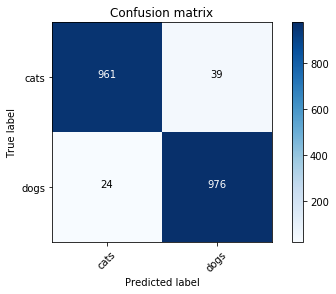

In [39]:
cm = confusion_matrix(val_classes, preds)
plot_confusion_matrix(cm, val_batches.class_indices)

In [40]:
vgg.model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  1792        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

In [41]:
model.pop()
for layer in model.layers: layer.trainable=False

In [42]:
vgg.model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  1792        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

In [43]:
model.add(Dense(2, activation='softmax'))

In [44]:
vgg.model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  1792        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

In [45]:
#nb: we now have an additional layer.

In [47]:
??vgg.finetune
#?? causes popup help info to appear.

In [48]:
gen=image.ImageDataGenerator()
batches = gen.flow(trn_data, trn_labels, batch_size=batch_size, shuffle=True)
val_batches = gen.flow(val_data, val_labels, batch_size=batch_size, shuffle=False)

In [49]:
def fit_model(model, batches, val_batches, nb_epoch=1):
    model.fit_generator(batches, samples_per_epoch=batches.n, nb_epoch=nb_epoch, 
                        validation_data=val_batches, nb_val_samples=val_batches.n)

In [50]:
opt = RMSprop(lr=0.1)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [51]:
fit_model(model, batches, val_batches, nb_epoch=2)
#should get loss: 0.6278 - acc: 0.9601 - val_loss: 0.4218 - val_acc: 0.9735 on 2nd epoch

Epoch 1/2
23000/23000 [==============================] - 607s - loss: 0.8054 - acc: 0.9473 - val_loss: 0.3046 - val_acc: 0.9810
Epoch 2/2
23000/23000 [==============================] - 605s - loss: 0.4794 - acc: 0.9695 - val_loss: 0.3001 - val_acc: 0.9810


In [52]:
model.evaluate(val_data, val_labels)
#expect [0.42180404308438973, 0.97350000000000003]

2000/2000 [==============================] - 49s    


[0.30006145000458539, 0.98099999999999998]

In [53]:
preds = model.predict_classes(val_data, batch_size=batch_size)
probs = model.predict_proba(val_data, batch_size=batch_size)[:,0]
probs[:8]

2000/2000 [==============================] - 48s    


array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.], dtype=float32)

[[974  26]
 [ 12 988]]


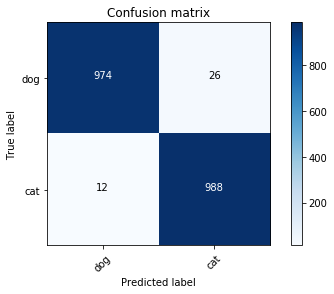

In [54]:
cm = confusion_matrix(val_classes, preds)
plot_confusion_matrix(cm, {'cat':0, 'dog':1})

In [ ]:
layers = model.layers
# Get the index of the first dense layer...
first_dense_idx = [index for index,layer in enumerate(layers) if type(layer) is Dense][0]
# ...and set this and all subsequent layers to trainable
for layer in layers[first_dense_idx:]: layer.trainable=True

In [ ]:
K.set_value(opt.lr, 0.01)
fit_model(model, batches, val_batches, 3)

Epoch 1/3
23000/23000 [==============================] - 603s - loss: 0.4166 - acc: 0.9736 - val_loss: 0.2980 - val_acc: 0.9810
Epoch 2/3
 7040/23000 [========>.....................] - ETA: 474s - loss: 0.4582 - acc: 0.9710

In [ ]:
for layer in layers[12:]: layer.trainable=True
K.set_value(opt.lr, 0.001)

In [ ]:
fit_model(model, batches, val_batches, 4)

In [ ]:
model.evaluate_generator(get_batches(path+'valid', gen, False, batch_size*2), val_batches.n)